# The following notebook includes:
* Was used dataset from raw audio files in wav format from the corpus with TED TALKS (claps, noise, somewhere pieces of music, so not only clean speech itself) 
* Feature extraction made using our approach of R-package
* Tried MLP network from the article
* Tried other ML algorithms with tuning parameters

In [1]:
from sphfile import SPHFile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
from sklearn.metrics import confusion_matrix, accuracy_score
import scipy.io.wavfile as sciow 
import os, sys, warnings, multiprocessing
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

##### Listened to kind of noise exists in the audio
##### Clapping and giggling

In [2]:
rate, audio = sciow.read('TED_audio/AlGore_2008.wav')
Audio(audio, rate=rate)

##### Little noise from the microphone

In [3]:
rate, audio = sciow.read('TED_audio/PeterGabriel_2006.wav')
Audio(audio, rate=rate)

In [4]:
try:
    data = pd.read_csv('TED_our_data.csv')
except FileNotFoundError:
    from process_input import make_csv_from_wav
    make_csv_from_wav(speakers_file='ted_speakers.csv', audios_directory='TED_audio', to_csv_file='TED_our_data.csv')
    data.to_csv('TED_our_data.csv')

In [5]:
data.shape

(774, 24)

##### There are unbalanced classes, so we bootstrap female samples and add them in order to make number of male and female equal

In [6]:
print('Men: {} examples\nWomen: {} examples'.format(*data.sex.value_counts()))

state = np.random.get_state()
np.random.seed(42)
indices = np.random.choice(data[data.sex == 0].index, 270)
np.random.set_state(state)
from sklearn.utils import shuffle
balanced_data = shuffle(pd.concat([data, data.iloc[indices]]), random_state=42)
print('\nAfter random sampling and adding women to dataframe\n')
print('Men: {} examples\nWomen: {} examples'.format(*balanced_data.sex.value_counts()))

Men: 523 examples
Women: 251 examples

After random sampling and adding women to dataframe

Men: 523 examples
Women: 521 examples


##### Now, classes are balanced and we can test models and use metric 'accuracy'

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.learning_curve import validation_curve

In [8]:
balanced_data = balanced_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

X_no_norm = balanced_data.drop(['sex'], axis=1)
y = balanced_data.sex

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_no_norm)

X = pd.DataFrame(X, columns = X_no_norm.columns)

In [9]:
def cross_val_model(model, X, y, verbose=2):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    print('{}: {:.3f}±{:.3f}'.format(model.__class__.__name__, np.mean(scores), np.std(scores)))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
boost = GradientBoostingClassifier(random_state = 42)
cross_val_model(boost, X, y, 0)

GradientBoostingClassifier: 0.688±0.025


In [13]:
forest = RandomForestClassifier(random_state = 42)
cross_val_model(forest, X, y, 0)

RandomForestClassifier: 0.712±0.038


In [14]:
svm = SVC(random_state = 42, probability=True)
cross_val_model(svm, X, y, 0)

SVC: 0.564±0.041


In [16]:
#stacked model
forest.fit(X_train, y_train)
svm.fit(X_train, y_train)
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest.predict_proba(X_test)[:, 1], 
                      'svm': svm.predict_proba(X_test)[:, 1], 
                      'boost': boost.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

GradientBoostingClassifier: 0.757±0.042


##### Feature importance

Feature ranking:
1. feature 10 (0.073638)
2. feature 20 (0.068176)
3. feature 12 (0.067302)
4. feature 18 (0.065592)
5. feature 7 (0.062471)
6. feature 17 (0.060932)
7. feature 5 (0.059587)
8. feature 3 (0.056592)
9. feature 0 (0.055105)
10. feature 11 (0.052335)
11. feature 4 (0.049872)
12. feature 6 (0.045735)
13. feature 16 (0.044787)
14. feature 13 (0.044267)
15. feature 2 (0.043558)
16. feature 19 (0.042752)
17. feature 8 (0.042221)
18. feature 15 (0.035043)
19. feature 1 (0.030035)
20. feature 14 (0.000000)
21. feature 9 (0.000000)


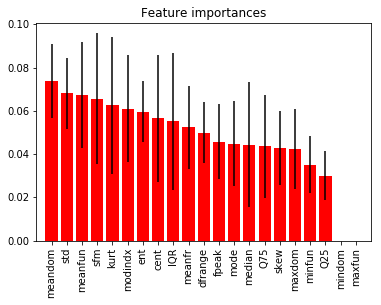

In [17]:
forest = RandomForestClassifier(random_state = 42)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[index] for index in indices]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

##### Mean fundamental frequency distribution

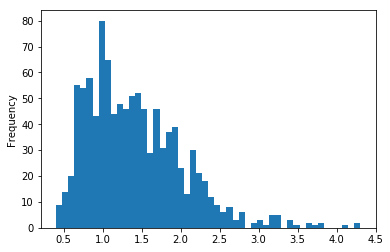

In [18]:
fig, ax = plt.subplots(1)
ax = balanced_data.meanfun.plot.hist(bins=50)
fig.savefig('ted_our_hist.png')

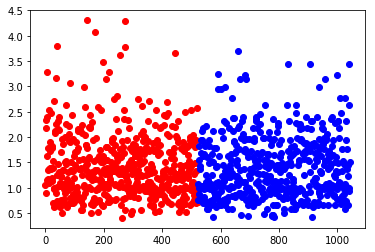

In [19]:
new_data = balanced_data
fig, ax = plt.subplots(1)

ax.plot(np.arange(np.sum(new_data.sex == 1)), new_data.meanfun[new_data.sex == 1], 'ro')
ax.plot(np.arange(np.sum(new_data.sex == 1), np.size(new_data.sex)), new_data.meanfun[new_data.sex == 0], 'bo')

##### Tune parameter for best models

##### SVM

In [20]:
parameters_s_new = {'C': np.arange(0.1,1.2, 0.1), 'gamma': np.arange(0.1,1, 0.1)}
svm_new = GridSearchCV(svm, param_grid = parameters_s_new, scoring='accuracy', verbose = 2, cv = 3)
svm_new.fit(X_train, y_train)

Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] ................................. C=0.1, gamma=0.2, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................. C=0.1, gamma=0.2, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] ................................. C=0.1, gamma=0.2, total=   0.0s
[CV] C=0.1, gamma=0.3 ................................................
[CV] ................................. C=0.1, gamma=0.3, total=   0.0s
[CV] C=0.1, gamma=0.3 ................................................
[CV] ................................. C=0.1, gamma=0.3, total=   0.0s
[CV] C=0.1, gamma=0.3 ................................................
[CV] ................................. C=0.1, gamma=0.3, total=   0.0s
[CV] C=0.1, gamma=0.4 ................................................
[CV] ................................. C=0.1, gamma=0.4, total=   0.0s
[CV] C=0.1, gamma=0.4 ................................................
[CV] ................................. C=0.1, gamma=0.4, total=   0.0s
[CV] C=0.1, gamma=0.4 ................................................
[CV] .

[CV] ................................. C=0.3, gamma=0.4, total=   0.0s
[CV] C=0.3, gamma=0.5 ................................................
[CV] ................................. C=0.3, gamma=0.5, total=   0.0s
[CV] C=0.3, gamma=0.5 ................................................
[CV] ................................. C=0.3, gamma=0.5, total=   0.0s
[CV] C=0.3, gamma=0.5 ................................................
[CV] ................................. C=0.3, gamma=0.5, total=   0.0s
[CV] C=0.3, gamma=0.6 ................................................
[CV] ................................. C=0.3, gamma=0.6, total=   0.0s
[CV] C=0.3, gamma=0.6 ................................................
[CV] ................................. C=0.3, gamma=0.6, total=   0.0s
[CV] C=0.3, gamma=0.6 ................................................
[CV] ................................. C=0.3, gamma=0.6, total=   0.0s
[CV] C=0.3, gamma=0.7 ................................................
[CV] .

[CV] ................................. C=0.5, gamma=0.7, total=   0.0s
[CV] C=0.5, gamma=0.7 ................................................
[CV] ................................. C=0.5, gamma=0.7, total=   0.0s
[CV] C=0.5, gamma=0.8 ................................................
[CV] ................................. C=0.5, gamma=0.8, total=   0.0s
[CV] C=0.5, gamma=0.8 ................................................
[CV] ................................. C=0.5, gamma=0.8, total=   0.0s
[CV] C=0.5, gamma=0.8 ................................................
[CV] ................................. C=0.5, gamma=0.8, total=   0.0s
[CV] C=0.5, gamma=0.9 ................................................
[CV] ................................. C=0.5, gamma=0.9, total=   0.0s
[CV] C=0.5, gamma=0.9 ................................................
[CV] ................................. C=0.5, gamma=0.9, total=   0.0s
[CV] C=0.5, gamma=0.9 ................................................
[CV] .

[CV] ................................. C=0.7, gamma=0.9, total=   0.0s
[CV] C=0.7, gamma=0.9 ................................................
[CV] ................................. C=0.7, gamma=0.9, total=   0.0s
[CV] C=0.7, gamma=0.9 ................................................
[CV] ................................. C=0.7, gamma=0.9, total=   0.0s
[CV] C=0.8, gamma=0.1 ................................................
[CV] ................................. C=0.8, gamma=0.1, total=   0.0s
[CV] C=0.8, gamma=0.1 ................................................
[CV] ................................. C=0.8, gamma=0.1, total=   0.0s
[CV] C=0.8, gamma=0.1 ................................................
[CV] ................................. C=0.8, gamma=0.1, total=   0.0s
[CV] C=0.8, gamma=0.2 ................................................
[CV] ................................. C=0.8, gamma=0.2, total=   0.0s
[CV] C=0.8, gamma=0.2 ................................................
[CV] .

[CV] ................................. C=1.0, gamma=0.2, total=   0.0s
[CV] C=1.0, gamma=0.2 ................................................
[CV] ................................. C=1.0, gamma=0.2, total=   0.0s
[CV] C=1.0, gamma=0.2 ................................................
[CV] ................................. C=1.0, gamma=0.2, total=   0.0s
[CV] C=1.0, gamma=0.3 ................................................
[CV] ................................. C=1.0, gamma=0.3, total=   0.0s
[CV] C=1.0, gamma=0.3 ................................................
[CV] ................................. C=1.0, gamma=0.3, total=   0.0s
[CV] C=1.0, gamma=0.3 ................................................
[CV] ................................. C=1.0, gamma=0.3, total=   0.0s
[CV] C=1.0, gamma=0.4 ................................................
[CV] ................................. C=1.0, gamma=0.4, total=   0.0s
[CV] C=1.0, gamma=0.4 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:   15.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1]), 'gamma': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [21]:
y_predict = svm_new.predict(X_test)
print(accuracy_score(y_predict, y_test))
conf_mat = pd.DataFrame(confusion_matrix(y_predict, y_test))
conf_mat

0.814492753623


,0,1
0,118,7
1,57,163


##### Random Forest

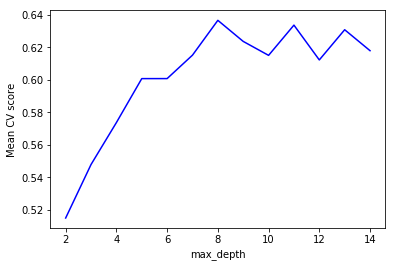

In [22]:
prange=np.arange(2,15,1)
train_scores, cv_scores = validation_curve(forest, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [23]:
forest_tune = RandomForestClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_rf = {'n_estimators': np.arange(5, 20, 1),  
                'min_samples_leaf': np.arange(1, 10, 1),
                'min_samples_split':np.arange(3, 5, 1)}
forest_tune = GridSearchCV(forest_tune, param_grid = parameters_rf, scoring='accuracy', verbose = 2, n_jobs = 4, cv = 5)
forest_tune.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=

[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=1, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=1, min

[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=11, total=   0.1s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=1, min_samples_split=4, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=1, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=1, min_sampl

[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=9, total=   0.0s
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=12 ........
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=2, min_sam

[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=2, min_samples_s

[Parallel(n_jobs=4)]: Done 208 tasks      | elapsed:    3.1s


[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=8 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=2, min_sampl

[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_split=4, n_estimators=17, total=   0.1s
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=6 .........
[CV] min_samples_leaf=2, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=2, min_samples_s

[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=14 ........
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=14, total=   0.0s
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=14 ........
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=3, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=3, min_sample

[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=13 ........
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=12, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=3, min_samples

[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=3, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=3, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=7 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=7, total=   0.0s
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=9 .........
[CV] min_samples_leaf=4, min_samp

[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=4, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=4, min_samples_s

[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=13, total=   0.0s
[CV] min_samples_leaf=4, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=4, min

[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=4, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=11, total=   0.0s
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=5, min

[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=5, total=   0.0s
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=5 .........
[CV] min_samples_leaf=5, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=5, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=5, min_samp

[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=16, total=   0.0s
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=5, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=5, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=6, min_sample

[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=13 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=6, min

[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=6, min_samples_split=3, n_estimators=19, total=   0.1s
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=11 ........
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=10, total=   0.1s
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=9 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=6, min_s

[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=6, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=6, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=7 .........
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=7, min_samples_sp

[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=16, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=7, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=5 .........
[CV]  min_samples_leaf=7, min_sampl

[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=12 ........
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=13, total=   0.1s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=14 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=15 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=7, min_samples_split=4, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=7, min_sample

[CV] min_samples_leaf=7, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=9, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=8 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=10 ........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=8, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=9 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=11 ........
[CV]  min_samples_leaf=7, min_samples_

[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=6 .........
[CV]  min_samples_leaf=8, min_samples_split=3, n_estimators=19, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=3, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=7 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=7, total=   0.0s
[CV] min_samples_leaf=8, min_sam

[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=5 .........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=15, total=   0.0s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=5, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=5 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=18, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=18 ........
[CV]  min_samples_leaf=8, min_samples

[Parallel(n_jobs=4)]: Done 1176 tasks      | elapsed:   16.6s


[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=17 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=6 .........
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=19 ........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=18, total=   0.1s
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=8, min_samples_split=4, n_estimators=16 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=6, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=6 .........
[CV]  min_samples_leaf=8, min_samples_split=4, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=8, min_sa

[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=17 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=16, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=15, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=15 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=14, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=14 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=16, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=16 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=17, total=   0.1s
[CV] min_samples_leaf=9, min_samples_split=3, n_estimators=18 ........
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=15, total=   0.1s
[CV]  min_samples_leaf=9, min_samples_split=3, n_estimators=14, total=   0.0s
[CV] min_samples_leaf=9, min

[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=14 ........
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=12 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=10 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=11, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=11 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=14, total=   0.0s
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=12, total=   0.0s
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=14 ........
[CV] min_samples_leaf=9, min_samples_split=4, n_estimators=13 ........
[CV]  min_samples_leaf=9, min_samples_split=4, n_estimators=10, total=   0.0s
[CV] min_samples_leaf=9, min_sample

[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:   19.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [24]:
y_predict_forest_tune = forest_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_forest_tune))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_forest_tune, y_test))
conf_mat

accuracy 0.686956521739


,0,1
0,118,51
1,57,119


##### Xgboost

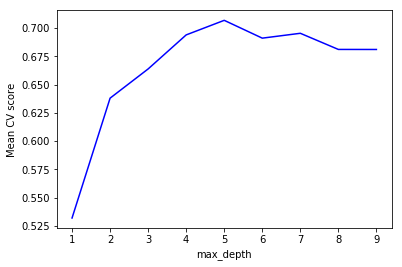

In [25]:
prange=np.arange(1,10,1)
train_scores, cv_scores = validation_curve(boost, X_train, y_train ,param_name='max_depth',
                                              param_range=prange, scoring = 'accuracy')

plt.xlabel('max_depth')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="b")

In [26]:
boost_tune = GradientBoostingClassifier(random_state = 42, max_depth = prange[np.argmax(np.mean(cv_scores, axis=1))])
parameters_b_new = {'learning_rate': np.arange(0.01, 0.13, 0.02), 'n_estimators': np.arange(50,150, 20)}
boosting_tune = GridSearchCV(boost_tune, param_grid = parameters_b_new, scoring='accuracy', verbose = 2, cv = 5)
boosting_tune.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.1s
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] .............. learning_rate=0.01, n_estimators=50, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .............. learning_rate=0.01, n_estimators=70, total=   0.1s
[CV] learning_rate=0.01, n_estimators=70 .............................
[CV] .

[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=90 .............................
[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=90 .............................
[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.2s
[CV] learning_rate=0.05, n_estimators=90 .............................
[CV] .............. learning_rate=0.05, n_estimators=90, total=   0.1s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.2s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.2s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] ............. learning_rate=0.05, n_estimators=110, total=   0.2s
[CV] learning_rate=0.05, n_estimators=110 ............................
[CV] .

[CV] ............. learning_rate=0.09, n_estimators=110, total=   0.2s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.2s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.2s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.2s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.2s
[CV] learning_rate=0.09, n_estimators=130 ............................
[CV] ............. learning_rate=0.09, n_estimators=130, total=   0.2s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .............. learning_rate=0.11, n_estimators=50, total=   0.1s
[CV] learning_rate=0.11, n_estimators=50 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([ 0.01,  0.03,  0.05,  0.07,  0.09,  0.11]), 'n_estimators': array([ 50,  70,  90, 110, 130])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [27]:
y_predict_boosting_tune = boosting_tune.predict(X_test)
print('accuracy', accuracy_score(y_test, y_predict_boosting_tune))
conf_mat = pd.DataFrame(confusion_matrix(y_predict_boosting_tune, y_test))
conf_mat

accuracy 0.713043478261


,0,1
0,137,61
1,38,109


##### Stacked model

In [28]:
boost.fit(X_train, y_train)
combo = pd.DataFrame({'forest': forest_tune.predict_proba(X_test)[:, 1], 
                      'svm': svm_new.predict_proba(X_test)[:, 1], 
                      'boost': boosting_tune.predict_proba(X_test)[:, 1]})
cross_val_model(boost, combo, y_test, 0)

def cross_val_model_new(model, X, y, verbose=2):
    cv = KFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, verbose=verbose, scoring='accuracy')
    return (np.mean(scores))

GradientBoostingClassifier: 0.809±0.058


In [29]:
state = np.random.get_state()
np.random.seed(42)
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Nadam
from keras.utils.np_utils import to_categorical

y = to_categorical(balanced_data.sex, 2)

def neural_network():
    x_input = Input(shape=(21,))

    hidden1 = Dense(units=64, activation='tanh')(x_input)
    hidden1 = Dropout(0.25)(hidden1)
    hidden2 = Dense(units=256, activation='tanh')(hidden1)
    hidden2 = Dropout(0.25)(hidden2)
    hidden3 = Dense(units=256, activation='tanh')(hidden2)
    hidden3 = Dropout(0.25)(hidden3)
    hidden4 = Dense(units=64, activation='tanh')(hidden3)

    y_output = Dense(units=2, activation='softmax')(hidden4)

    model = Model(inputs=x_input, outputs=y_output)
    model.compile(loss='kullback_leibler_divergence', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [34]:
from sklearn.model_selection import StratifiedKFold

kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 150
batch_size = 32

scores = []
for train, test in kFold.split(X, y[:, 0]):
    model = neural_network()
    model.fit(X.values[train], y[train], 
              validation_data=(X.values[test], y[test]), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(X.values[test], y[test], verbose=0)
    print('Accuracy: {:.3f}'.format(score[1]))
    scores.append(score[1])
print('Neural network: {:.3f}±{:.3f}'.format(np.mean(scores), np.std(scores)))
np.random.set_state(state)

Accuracy: 0.724
Accuracy: 0.694
Accuracy: 0.713
Accuracy: 0.832
Accuracy: 0.736
Neural network: 0.740±0.048


In [35]:
print('Choosen metric is accuracy')
print('Neural network from the article: {:.3f}'.format(np.mean(scores), np.std(scores)))
print('SVM: {:.3f}'.format(accuracy_score(y_predict, y_test)))
print('Random forest: {:.3f}'.format(accuracy_score(y_test, y_predict_forest_tune)))
print('Xgboost: {:.3f}'.format(accuracy_score(y_test, y_predict_boosting_tune)))
print('Stacked model: {:.3f}'.format(cross_val_model_new(boost, combo, y_test, 0)))

Choosen metric is accuracy
Neural network from the article: 0.740
SVM: 0.814
Random forest: 0.687
Xgboost: 0.713
Stacked model: 0.809


##### Best one is SVM, Stacked model is close. Accuracy generally decreased, because of noise.